## Load images

In [ ]:
# Please specify path_to_utfvp_database
path_to_utfvp_database = '<path_to_utfvp_database>'

In [ ]:
print("start the code")
import numpy as np
from bob.bio.vein.configurations.utfvp import database
import bob.io.base

from bob.bio.vein.preprocessor import NoCrop, TomesLeeMask, HuangNormalization, \
    NoFilter, Preprocessor

preprocessor = Preprocessor(
    crop=NoCrop(),
    mask=TomesLeeMask(),
    normalize=HuangNormalization(),
    filter=NoFilter(),
    )


from bob.bio.vein.extractor import WideLineDetector
extractor = WideLineDetector()


all_Files = database.objects(protocol='nom', groups='world')
    
######################################################################    
all_imgs=[]
all_feats=[]
all_client_ids=[]
#obj=database.objects()[0]
print("preparing data")
mylog_csv_path="my_log"
mylog=open(mylog_csv_path,'w')
mylog.close()
for i,obj in enumerate(all_Files):
    #672: for split train-test.  (it exclude id <29 which is used for world and dev partition)
    # Note by this split 'dev' group can be used for test(corresponds to :240-671)
    path=obj.make_path(path_to_utfvp_database,'.png')
    image = bob.io.base.load(path)
    #image, mask = preprocessor(image)
    image_and_mask = preprocessor(image)
    feature = extractor(image_and_mask)
    
    all_imgs.append(image)
    all_feats.append(feature)
    all_client_ids.append(obj.client_id)
    
    #if i==50:
    #    break
    mylog=open(mylog_csv_path,'a')
    print('%d/%d' % (i+1, len(all_Files)), end='\r',  file=mylog)
    mylog.close()
        

all_imgs  = np.array(all_imgs)/255.0
all_feats = np.array(all_feats)

## Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=7,
                             width_shift_range=0.025,
                             height_shift_range=0.025,
                             channel_shift_range=0.075,
                             zoom_range=(0.95,1.05)
                             )

all_imgs = np.reshape(all_imgs, [all_imgs.shape[0], all_imgs.shape[1], all_imgs.shape[2], 1])
all_imgs_aug       = np.copy(all_imgs)
all_client_ids_aug = all_client_ids.copy()

itr=0
for gen_imgs, gen_lables in datagen.flow(all_imgs, 
                                         all_client_ids,
                                         batch_size = all_imgs.shape[0],
                                         seed=itr
                                        ):
    itr += 1
    print(itr, all_imgs_aug.shape[0])
    all_imgs_aug = np.append(all_imgs_aug, 
                             gen_imgs,
                             axis=0)
    for ID in gen_lables:
        all_client_ids_aug.append(ID)
    
    if itr==19:
        break
print("Total Aug images:", all_imgs_aug.shape[0])


np.save('all_imgs_aug.npy', all_imgs_aug) 

import pickle
with open('all_client_ids_aug.pkl','wb') as f:
    pickle.dump(all_client_ids_aug,f)

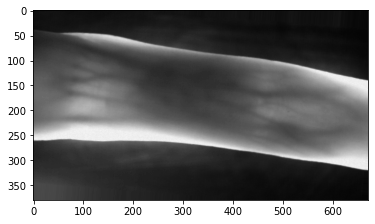

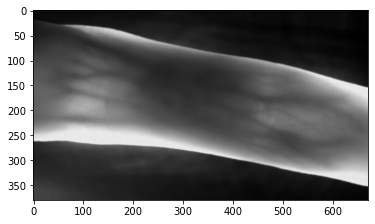

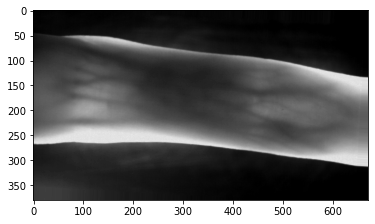

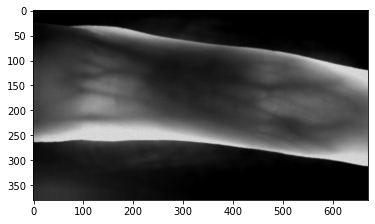

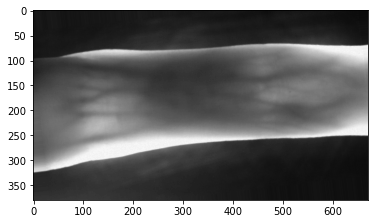

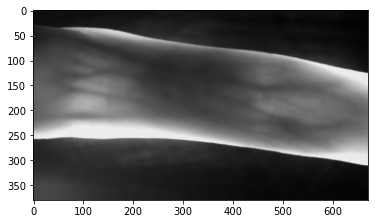

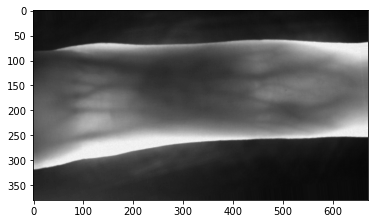

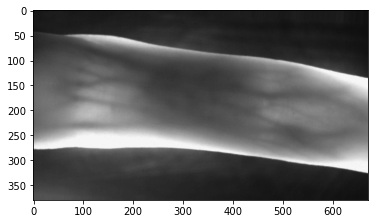

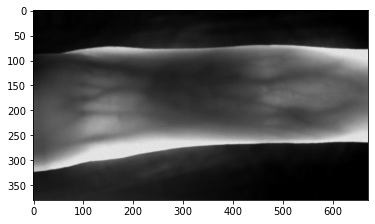

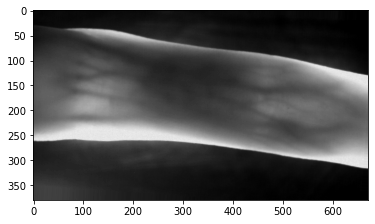

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img 
   
# Initialising the ImageDataGenerator class. 
# We will pass in the augmentation parameters in the constructor. 
datagen = ImageDataGenerator(rotation_range=7,
                             width_shift_range=0.025,
                             height_shift_range=0.025,
                             channel_shift_range=0.075,
                             zoom_range=(0.95,1.05)
                            )
import matplotlib.pyplot as plt
all_ims = np.reshape(all_imgs, [all_imgs.shape[0], all_imgs.shape[1], all_imgs.shape[2], 1])
i=0
for im in datagen.flow(all_ims[:1,:,:,:], batch_size = 10):
    arr = np.asarray(im[0,:,:,0])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=1)
    plt.show()
    i+=1
    if i==10:
        break

***